# Imports

In [437]:
# data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter

# machine learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

# forest visualization libraries
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

In [438]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")

In [439]:
print(f"Dataframe shape: {df.shape}")
df.head(10)

Dataframe shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
6,53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
7,10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
9,60491,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1


# Cleaning / Preprocessing

In [440]:
# get rid of null values in BMI
df = df.dropna()

# get rid of unknown values in smoking_status
df = df[df['smoking_status'] != 'Unknown']

print(f"# of rows after dropping null values: {len(df)}") # shows # of rows in dataset reducing by around 200

# of rows after dropping null values: 3426


In [441]:
# use LabelEncoder to transform labels to number equivalents
def encode_columns(categorical_columns):
  label_encoder = LabelEncoder()

  for category in categorical_columns:
    df[category] = label_encoder.fit_transform(df[category]) # in-place transformation

  return df

categorical_columns = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
df = encode_columns(categorical_columns)
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,0,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,1,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,2,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,1,1
5,56669,1,81.0,0,0,1,2,1,186.21,29.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5100,68398,1,82.0,1,0,1,3,0,71.97,28.3,1,0
5102,45010,0,57.0,0,0,1,2,0,77.93,21.7,1,0
5106,44873,0,81.0,0,0,1,3,1,125.20,40.0,1,0
5107,19723,0,35.0,0,0,1,3,0,82.99,30.6,1,0


# Base Performance

In [377]:
# gives accuracy_score, precision_score, recall_score, confusion_matrix, f1_score for model
def use_metrics(y, y_pred):
  # calculate scores
  accuracy = accuracy_score(y, y_pred)   # not very useful for imbalanced data but still included to show overall picture
  precision = precision_score(y, y_pred) # used in F1 score calculation
  recall = recall_score(y, y_pred)       # useful for false negatives, which are particularly important in this case
  roc_auc = roc_auc_score(y, y_pred)     # true positive vs false positive
  f1 = f1_score(y, y_pred)               # useful for reducing precision and recall to one number
  cm = confusion_matrix(y, y_pred)       # useful for visualizing false negatives and false positives

  # print/display scores
  print(f"Accuracy: {accuracy:.2f}")
  print(f"Precision: {precision:.2f}")
  print(f"Recall: {recall:.2f}")
  print(f"ROC AUC: {roc_auc:.2f}")
  print(f"F1: {f1:.2f}")
  ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [378]:
# split into features and target for model training
X = df.drop('stroke', axis=1)
y = df['stroke']

# split 20% of data into testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

# show shapes and distributions
train, test = Counter(y_train)[1], Counter(y_test)[1]
print(f"Training shapes: {X_train.shape} {y_train.shape}")
print(f"Test shapes: {X_test.shape} {y_test.shape}")
print(f"Class distribution: {(train / len(y_train)):.2f} {(test / len(y_test)):.2f}")

Training shapes: (2740, 11) (2740,)
Test shapes: (686, 11) (686,)
Class distribution: 0.05 0.05


Accuracy: 0.95
Precision: 0.50
Recall: 0.03
ROC AUC: 0.51
F1: 0.05


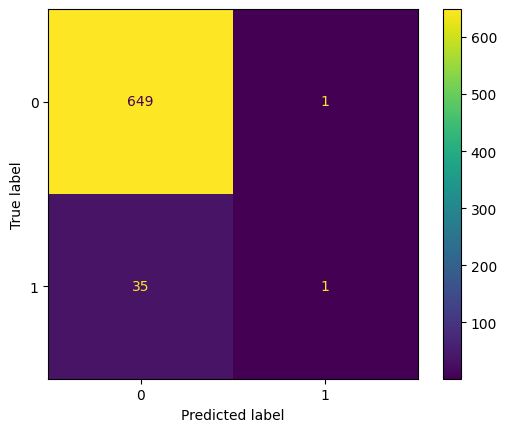

In [379]:
# instantiate, train, and evaluate a RandomForestClassifier with default settings
rf = RandomForestClassifier(random_state=28)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
use_metrics(y_test, y_pred)

# Exploration

In [121]:
df.sample(n=15, random_state=82) # random sample of data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3333,59872,0,38.0,0,0,1,2,0,80.82,49.3,1,0
4221,64931,1,37.0,0,0,1,2,0,131.05,27.2,1,0
3708,36825,0,39.0,0,0,1,2,0,103.12,29.9,0,0
579,8328,0,54.0,0,0,1,2,0,118.51,40.6,1,0
4072,31390,0,61.0,0,0,1,2,0,71.40,29.2,0,0
2849,40548,1,52.0,0,0,1,2,0,223.58,35.8,1,0
526,65574,0,54.0,0,0,1,2,1,129.16,32.4,1,0
371,43232,0,18.0,0,0,0,2,1,80.05,24.2,1,0
2376,58820,1,56.0,0,0,1,2,0,86.36,27.7,0,0
3932,33790,0,23.0,0,0,0,2,0,100.06,28.6,1,0


Text(0, 0.5, 'count')

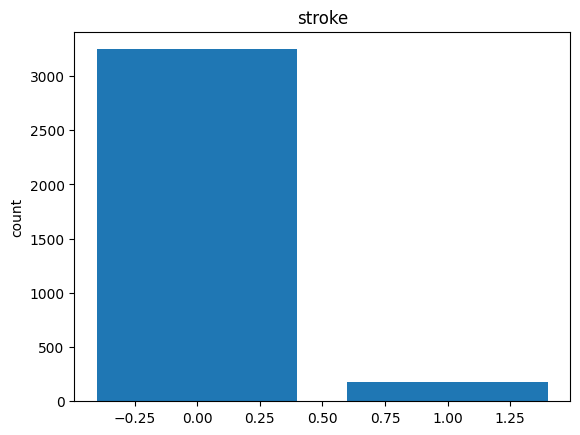

In [122]:
# graphing main variable
counter = df["stroke"].value_counts() # grab stroke column's unique row counts

plt.bar(counter.index, counter.values)
plt.title('stroke')
plt.ylabel('count')

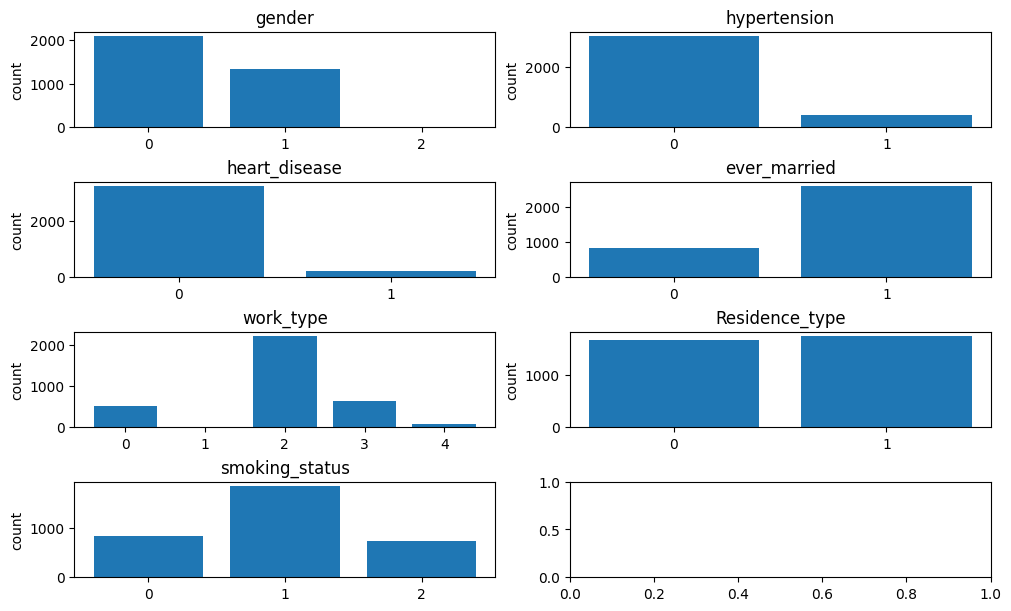

In [125]:
# graphing categorical variables
columns = ["gender", "hypertension", "heart_disease", "ever_married", "work_type", "Residence_type", "smoking_status"]

fig, axs = plt.subplots(4, 2, figsize=(10, 6), layout='constrained')

for i, column in enumerate(columns):
    category_count = df[column].value_counts()
    axs.flat[i].bar(category_count.index, category_count.values)

    axs.flat[i].set_title(column)
    axs.flat[i].set_ylabel('count')
    axs.flat[i].xaxis.set_major_locator(MaxNLocator(integer=True)) # remove extra ticks

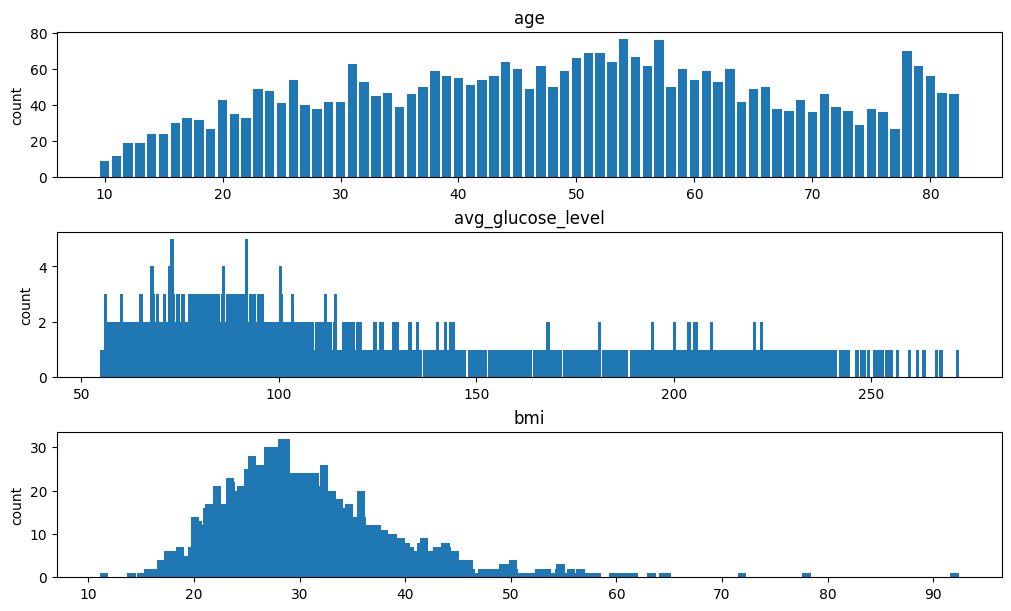

In [126]:
# graphing continuous variables
columns = ['age', 'avg_glucose_level', 'bmi']

fig, axs = plt.subplots(3, figsize=(10, 6), layout='constrained')

for i, column in enumerate(columns):
  column_count = df[column].value_counts()
  axs[i].bar(column_count.index, column_count.values)

  axs[i].set_title(column)
  axs[i].set_ylabel('count')

# bmi is already in normal scale, age and avg_glucose_level are not
# no particular imbalances apparent, except extreme outliers in BMI

# Feature Engineering

In [442]:
# discretize bmi and age

# source for BMI categories: https://www.cdc.gov/obesity/basics/adult-defining.html#:~:text=If%20your%20BMI%20is%20less,falls%20within%20the%20obesity%20range.
bmi_bin_edges = [0, 18.5, 24.9, 29.9, 150]
bmi_bin_labels = ['underweight', 'normal', 'overweight', 'obese']

# source for age categories: https://www.nih.gov/nih-style-guide/age
age_bin_edges = [0, 12, 18, 65, 150]
age_bin_labels = ['infant_child', 'teen', 'adult', 'older_adult']

# use pd.cut() to bin the age and bmi categories
df['bmi_category'] = pd.cut(df['bmi'], bins=bmi_bin_edges, labels=bmi_bin_labels, right=False)
df['age_category'] = pd.cut(df['age'], bins=age_bin_edges, labels=age_bin_labels, right=False)

df.drop("id", axis=1, inplace=True) # drop useless column
df.drop('bmi', axis=1, inplace=True)
df.drop('age', axis=1, inplace=True)

df

,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi_category,age_category
0,1,0,1,1,2,1,228.69,0,1,obese,older_adult
2,1,0,1,1,2,0,105.92,1,1,obese,older_adult
3,0,0,0,1,2,1,171.23,2,1,obese,adult
4,0,1,0,1,3,0,174.12,1,1,normal,older_adult
5,1,0,0,1,2,1,186.21,0,1,overweight,older_adult
...,...,...,...,...,...,...,...,...,...,...,...
5100,1,1,0,1,3,0,71.97,1,0,overweight,older_adult
5102,0,0,0,1,2,0,77.93,1,0,normal,adult
5106,0,0,0,1,3,1,125.20,1,0,obese,older_adult
5107,0,0,0,1,3,0,82.99,1,0,obese,adult


In [443]:
# label encode new columns
categorical_columns = ["bmi_category", "age_category"]
df = encode_columns(categorical_columns)

# note that scaling is not needed for decision trees as no distance-based measurements are made
# also note that not much preprocessing is required for decision trees
# all features included are already known to be relevant to stroke, so dropping features is not needed

In [444]:
print(f"New shape: {df.shape}")
df.head() # data after engineering

New shape: (3426, 11)


,gender,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,smoking_status,stroke,bmi_category,age_category
0,1,0,1,1,2,1,228.69,0,1,1,2
2,1,0,1,1,2,0,105.92,1,1,1,2
3,0,0,0,1,2,1,171.23,2,1,1,0
4,0,1,0,1,3,0,174.12,1,1,0,2
5,1,0,0,1,2,1,186.21,0,1,2,2


# Random Forest Training

In [445]:
# split into features and target for model training
X = df.drop('stroke', axis=1)
y = df['stroke']

# split 10% of data into testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

# under sample training data to train on a higher distribution of patients with stroke
# under sampling sacrifices training data, but was chosen over over sampling due to over sampling causing overfit
undersampler = RandomUnderSampler(sampling_strategy=0.1, random_state=28)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# show shapes and distributions
train, test = Counter(y_train_resampled)[1], Counter(y_test)[1]
print(f"Training shapes: {X_train_resampled.shape} {y_train_resampled.shape}")
print(f"Test shapes: {X_test.shape} {y_test.shape}")
print(f"Class distribution: {(train / len(y_train_resampled)):.2f} {(test / len(y_test)):.2f}")

rf.get_params()

Training shapes: (1584, 10) (1584,)
Test shapes: (686, 10) (686,)
Class distribution: 0.09 0.05


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': {0: 1, 1: 5},
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 28,
 'verbose': 0,
 'warm_start': False}

In [446]:
# instantiate new RandomForestClassifier
# use custom class_weight to prioritize correct classification of stroke=1
# use entropy criterion to prioritize quick classfication
rf = RandomForestClassifier(class_weight = {0:1, 1:5}, random_state=28)

rf.fit(X_train_resampled, y_train_resampled)

y_train_pred = rf.predict(X_train_resampled)
y_pred = rf.predict(X_test)
print(f"Results on training data: {Counter(y_train_pred)}")
print(f"Results on test data: {Counter(y_pred)}")

Results on training data: Counter({0: 1440, 1: 144})
Results on test data: Counter({0: 672, 1: 14})


Metrics for training data:
Accuracy: 1.00
Precision: 1.00
Recall: 1.00
ROC AUC: 1.00
F1: 1.00


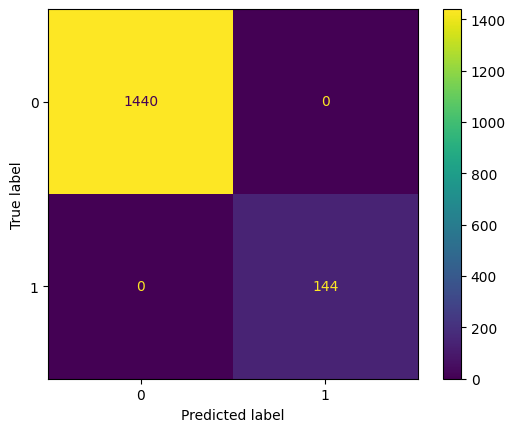

In [447]:
print("Metrics for training data:")
use_metrics(y_train_resampled, y_train_pred)

Metrics for test data:
Accuracy: 0.94
Precision: 0.29
Recall: 0.11
ROC AUC: 0.55
F1: 0.16


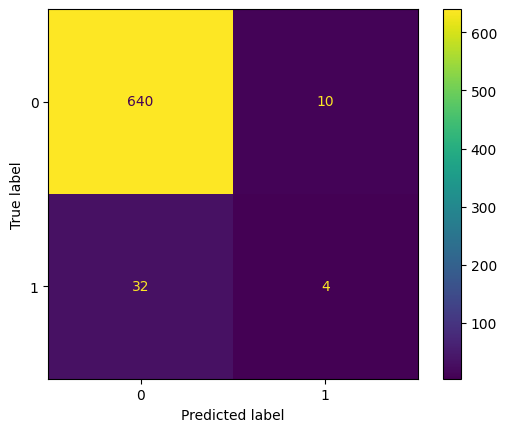

In [448]:
print("Metrics for test data:")
use_metrics(y_test, y_pred)

# base performance: 0.94 accuracy and 0.16 F1 score
# note that accuracy is not very useful for imbalanced datasets like this dataset

In [449]:
# show how model made it's predictions

# create list of feature and importance
importances = list(rf.feature_importances_)
feature_list = list(X.columns)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# sort by importance and print
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print(f'{pair[0]} {pair[1]}') for pair in feature_importances]

avg_glucose_level 0.44
age_category 0.14
work_type 0.07
smoking_status 0.07
bmi_category 0.07
hypertension 0.06
Residence_type 0.05
gender 0.04
heart_disease 0.04
ever_married 0.03


[None, None, None, None, None, None, None, None, None, None]

# Hyperparameter Tuning

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best hyperparameters:  {'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.79
Precision: 0.15
Recall: 0.67
ROC AUC: 0.73
F1: 0.25


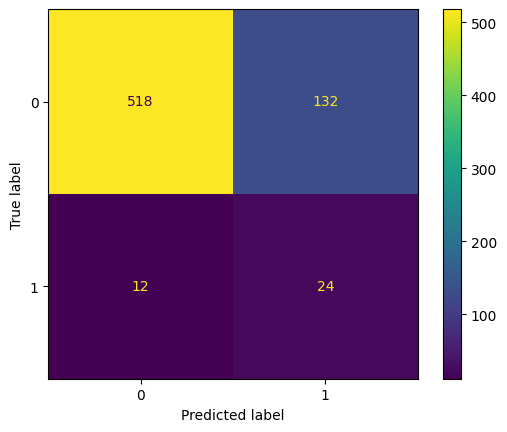

In [450]:
param_grid = {'max_features': ['sqrt', 'log2', None], # features being used
              'n_estimators': [10, 25, 50, 75],       # number of trees
              'max_depth': [2, 6, None],              # tree height
              'min_samples_split': [2, 6, 10],        # samples to be split
              'min_samples_leaf': [1, 2, 6]           # samples in every leaf
             }

grid_cv = GridSearchCV(rf,
                       param_grid = param_grid,
                       scoring="recall", # optimize to reduce false negatives, also improve F1 implicity
                       n_jobs=-1,        # use all cores
                       verbose=2,        # print number of fits
                       cv=5              # 5-fold stratified cross validation
                       )

grid_cv.fit(X_train_resampled, y_train_resampled)
best_rf = grid_cv.best_estimator_
print('Best hyperparameters: ',  grid_cv.best_params_)

y_pred = best_rf.predict(X_test)
use_metrics(y_test, y_pred)

# Tree Visualization


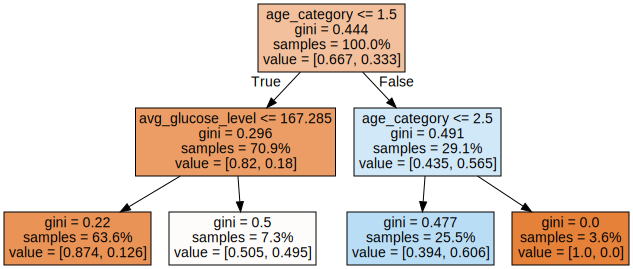

In [462]:
for i in range(1): # change range to show more trees
    tree = best_rf.estimators_[i]
    tree_data = export_graphviz(tree,
                                feature_names=X.columns,
                                filled=True,
                                proportion=True)
    graph = graphviz.Source(tree_data)
    display(graph)